In [1]:
##  IN STATE TUITION INFLATION

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.colors
import plotly.graph_objects as go

In [3]:
# Define the file path
file_path = Path("Resources/instate_tuition.csv")

In [4]:
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

                  In 2023 Dollars STATE In-State Tuition and Fees Unnamed: 3  \
0                             NaN   NaN                   2013-14    2014-15   
1  University of Alaska Fairbanks    AK                    $7,861     $7,986   
2           University of Alabama    AL                   $12,406    $12,694   
3          University of Arkansas    AR                   $10,263    $10,606   
4           University of Arizona    AZ                   $13,641    $14,155   

  Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ...  \
0    2015-16    2016-17    2017-18    2018-19    2019-20    2020-21  ...   
1     $8,779     $9,154     $9,380     $9,849    $10,213    $10,611  ...   
2    $13,122    $13,341    $13,450    $13,129    $12,895    $13,731  ...   
3    $10,996    $11,239    $11,306    $11,119    $11,221    $11,084  ...   
4    $14,713    $14,996    $14,818    $15,208    $15,072    $15,007  ...   

  Unnamed: 21 Unnamed: 22 Unnamed: 23 Unnamed: 24 Unnamed: 25 

In [5]:
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, header=1)  # Use the second row as header

# Remove any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Rename columns 'Unnamed: 0' and 'Unnamed: 1'
df.rename(columns={'Unnamed: 0': 'Institution', 'Unnamed: 1': 'STATE'}, inplace=True)

# Display the first few rows to understand the structure
print(df.head())

                          Institution STATE  2013-14  2014-15  2015-16  \
0      University of Alaska Fairbanks    AK   $7,861   $7,986   $8,779   
1               University of Alabama    AL  $12,406  $12,694  $13,122   
2              University of Arkansas    AR  $10,263  $10,606  $10,996   
3               University of Arizona    AZ  $13,641  $14,155  $14,713   
4  University of California: Berkeley    CA  $16,888  $16,758  $17,330   

   2016-17  2017-18  2018-19  2019-20  2020-21  ... 2016-17.1 2017-18.1  \
0   $9,154   $9,380   $9,849  $10,213  $10,611  ...    $7,184    $7,518   
1  $13,341  $13,450  $13,129  $12,895  $13,731  ...   $10,470   $10,780   
2  $11,239  $11,306  $11,119  $11,221  $11,084  ...    $8,820    $9,062   
3  $14,996  $14,818  $15,208  $15,072  $15,007  ...   $11,769   $11,877   
4  $17,183  $17,377  $17,275  $17,050  $16,909  ...   $13,485   $13,928   

  2018-19.1 2019-20.1 2020-21.1  2021-22.1 2022-23.1 2023-24.1 1-Year.1  \
0    $8,087    $8,538    $8,9

In [6]:
# Melt the DataFrame to long format
df_melted = pd.melt(df, id_vars=["Institution", "STATE"], var_name="Year", value_name="Tuition")

# Extract only relevant rows (e.g., years and tuition data)
# You may need to filter out non-year rows (like '1-Year' and '5-Year' percentage change)
df_melted = df_melted[df_melted["Year"].str.contains(r'^\d{4}-\d{2}$')]

# Optionally, rename columns for clarity
df_melted.rename(columns={"STATE": "State", "Tuition": "Tuition (USD)"}, inplace=True)

# Convert Tuition to numeric, removing any unwanted characters like commas or dollar signs
df_melted["Tuition (USD)"] = df_melted["Tuition (USD)"].replace('[\$,]', '', regex=True).astype(float)

# Drop the 'Institution' column
df_melted_no_institution = df_melted.drop(columns=["Institution"])

print(df_melted_no_institution)

    State     Year  Tuition (USD)
0      AK  2013-14         7861.0
1      AL  2013-14        12406.0
2      AR  2013-14        10263.0
3      AZ  2013-14        13641.0
4      CA  2013-14        16888.0
..    ...      ...            ...
545    VT  2023-24        18890.0
546    WA  2023-24        12643.0
547    WI  2023-24        11205.0
548    WV  2023-24         9648.0
549    WY  2023-24         6698.0

[550 rows x 3 columns]


In [7]:
# Calculate the average tuition across all years for each state
avg_in_tuition = df_melted_no_institution.groupby('State')['Tuition (USD)'].mean().sort_values(ascending=False).reset_index()

# Merge this average tuition back to the original data
df_sorted = pd.merge(df_melted_no_institution, avg_in_tuition, on='State', suffixes=('', '_Average'))

# Sort the data based on the average tuition
df_sorted = df_sorted.sort_values(by='Tuition (USD)_Average', ascending=False)
print(df_sorted)

    State     Year  Tuition (USD)  Tuition (USD)_Average
37     PA  2013-14        22307.0           21893.545455
387    PA  2020-21        21801.0           21893.545455
287    PA  2018-19        22475.0           21893.545455
487    PA  2022-23        20154.0           21893.545455
187    PA  2016-17        22809.0           21893.545455
..    ...      ...            ...                    ...
299    WY  2018-19         6577.0            6495.727273
349    WY  2019-20         6676.0            6495.727273
399    WY  2020-21         6842.0            6495.727273
449    WY  2021-22         6885.0            6495.727273
549    WY  2023-24         6698.0            6495.727273

[550 rows x 4 columns]


In [8]:
# Generate the GeoHeatmap
def plotInstateheatmap():
        fig = px.choropleth(
        df_sorted,
        locations='State',
        locationmode='USA-states',
        color='Tuition (USD)_Average',
        hover_name='State',
        color_continuous_scale='balance', 
        scope='usa',
        title='In-State Tuition Costs by State'
        )
        fig.show()

In [9]:
region_mapping_abbrev = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 
                  'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 
                'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 
              'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 
              'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 
             'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

# Function to map states to their regions
def get_region(state):
    for region, states in region_mapping_abbrev.items():
        if state in states:
            return region
    return 'Unknown'  # For any states not found in the mapping
    
# Apply the region mapping to the DataFrame
avg_in_tuition['Region'] = avg_in_tuition['State'].apply(get_region)

# Add 'Region' column to the DataFrame
avg_in_tuition_region = avg_in_tuition.groupby('Region')['Tuition (USD)'].mean().reset_index()

# Sort the data first by region and then by tuition in descending order
sorted_in_tuition = avg_in_tuition.sort_values(by=['Region', 'Tuition (USD)'], ascending=[True, False])

# Display the filled DataFrame
print(sorted_in_tuition)


   State  Tuition (USD)     Region
3     IL   19249.818182    Midwest
7     MI   18038.727273    Midwest
9     MN   17587.090909    Midwest
24    KS   13174.454545    Midwest
25    OH   13128.545455    Midwest
27    IN   12955.000000    Midwest
29    WI   12733.454545    Midwest
32    MO   12430.727273    Midwest
34    IA   10946.181818    Midwest
35    ND   10889.181818    Midwest
38    NE   10742.636364    Midwest
39    SD   10607.090909    Midwest
0     PA   21893.545455  Northeast
1     NH   21621.636364  Northeast
2     VT   21334.272727  Northeast
5     CT   18939.090909  Northeast
6     MA   18549.818182  Northeast
8     NJ   17897.000000  Northeast
10    RI   16854.000000  Northeast
22    ME   13493.727273  Northeast
33    NY   11885.363636  Northeast
4     VA   19080.363636      South
12    DE   16450.545455      South
13    TN   15283.727273      South
15    SC   14512.818182      South
19    KY   14104.545455      South
21    GA   13787.636364      South
23    OK   13288.636

In [10]:
def plotinstateregionwise():
        
        # Define color scales for each region
        color_scales = {
            'Northeast': plotly.colors.sequential.Greens,
            'Midwest': plotly.colors.sequential.Blues,
            'South': plotly.colors.sequential.Purples,
            'West': plotly.colors.sequential.Oranges
        }
        # Map each region to its respective color for the legend
        region_colors = {
            'Northeast': color_scales['Northeast'][len(color_scales['Northeast'])//2],
            'Midwest': color_scales['Midwest'][len(color_scales['Midwest'])//2],
            'South': color_scales['South'][len(color_scales['South'])//2],
            'West': color_scales['West'][len(color_scales['West'])//2],
        }
        # Initialize the figure
        fig = go.Figure()
        
        # Create a choropleth map separately for each region and add them to the figure
        for region, color_scale in color_scales.items():
            region_data = sorted_in_tuition[sorted_in_tuition['Region'] == region]
            fig.add_trace(go.Choropleth(
                locations=region_data['State'],
                z=region_data['Tuition (USD)'],
                locationmode='USA-states',
                colorscale=color_scale,
                text=region_data['State'],
                hoverinfo='location+z+text',
            ))
        # Add annotations for the color codes with specific regions
        annotations = []
        x_position = 0.01  # Start position for the legend
        y_position = 0.85  # Vertical start position
        
        for region, color in region_colors.items():
            annotations.append(dict(
                x=x_position,
                y=y_position,
                xref="paper",
                yref="paper",
                showarrow=False,
                text=f"<b>{region}</b>",
                font=dict(
                    size=14,
                    color=color
                ),
                align="left"
            ))
            y_position -= 0.05  # Move down for the next entry
            
        # Update the layout to include the annotations and increase map size
        fig.update_layout(
            title_text='Average In State Tuition Costs Increase Regionwise',
            geo=dict(
                scope='usa',
                projection=dict(type='albers usa'),        
            ),
            annotations=annotations,  # Add the custom legend as annotations
            width=2000,
            height=1200,
        )
        
        # Display the figure
        fig.show()

In [11]:
# Calculate the average tuition across all states for each year
yearly_avg_tuition = df_melted_no_institution.groupby('Year')['Tuition (USD)'].mean().reset_index()

# Rename the column for clarity
yearly_avg_tuition.rename(columns={"Tuition (USD)": "Yearly Average Tuition (USD)"}, inplace=True)

# # Merge & sort the data based on the year
df_with_yearly_avg = pd.merge(df_melted_no_institution, yearly_avg_tuition, on="Year")


# Display the updated DataFrame to verify the change
print(df_with_yearly_avg)


    State     Year  Tuition (USD)  Yearly Average Tuition (USD)
0      AK  2013-14         7861.0                      13125.90
1      AL  2013-14        12406.0                      13125.90
2      AR  2013-14        10263.0                      13125.90
3      AZ  2013-14        13641.0                      13125.90
4      CA  2013-14        16888.0                      13125.90
..    ...      ...            ...                           ...
545    VT  2023-24        18890.0                      12852.22
546    WA  2023-24        12643.0                      12852.22
547    WI  2023-24        11205.0                      12852.22
548    WV  2023-24         9648.0                      12852.22
549    WY  2023-24         6698.0                      12852.22

[550 rows x 4 columns]


In [12]:
# Calculate year-over-year growth rates for each state
df_growth = df_with_yearly_avg.copy()
df_growth['Tuition Growth (%)'] = df_growth.groupby('State')['Tuition (USD)'].pct_change() * 100

# Drop the rows where 'Year' is '2013-14' and 'Tuition Growth (%)' is NaN
df_growth = df_growth[~((df_growth['Year'] == '2013-14') & (df_growth['Tuition Growth (%)'].isna()))]
print(df_growth)

    State     Year  Tuition (USD)  Yearly Average Tuition (USD)  \
50     AK  2014-15         7986.0                      13259.84   
51     AL  2014-15        12694.0                      13259.84   
52     AR  2014-15        10606.0                      13259.84   
53     AZ  2014-15        14155.0                      13259.84   
54     CA  2014-15        16758.0                      13259.84   
..    ...      ...            ...                           ...   
545    VT  2023-24        18890.0                      12852.22   
546    WA  2023-24        12643.0                      12852.22   
547    WI  2023-24        11205.0                      12852.22   
548    WV  2023-24         9648.0                      12852.22   
549    WY  2023-24         6698.0                      12852.22   

     Tuition Growth (%)  
50             1.590128  
51             2.321457  
52             3.342103  
53             3.768052  
54            -0.769777  
..                  ...  
545          

In [13]:
##  OUT OF STATE TUITION INFLATION

In [14]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.colors
import plotly.graph_objects as go

In [15]:
file_path_1 = "Resources/outstate_tuition.csv"

In [16]:
# Load the dataset
df_out = pd.read_csv(file_path_1)
# Display the first few rows of the DataFrame
print(df_out.head())

                  In 2023 Dollars STATE Out-of-State Tuition and Fees  \
0                             NaN   NaN                       2013-14   
1  University of Alaska Fairbanks    AK                       $24,875   
2           University of Alabama    AL                       $31,441   
3          University of Arkansas    AR                       $25,042   
4           University of Arizona    AZ                       $35,541   

  Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8  \
0    2014-15    2015-16    2016-17    2017-18    2018-19    2019-20   
1    $25,193    $26,818    $27,847    $28,581    $29,543    $31,351   
2    $32,231    $33,483    $34,341    $35,059    $35,599    $36,186   
3    $26,227    $28,162    $29,521    $30,328    $30,652    $30,949   
4    $38,007    $42,064    $45,894    $44,051    $44,315    $43,782   

  Unnamed: 9  ... Unnamed: 21 Unnamed: 22 Unnamed: 23 Unnamed: 24 Unnamed: 25  \
0    2020-21  ...     2016-17     2017-18     2018-19

In [17]:
# Read the CSV file into a DataFrame
df_out = pd.read_csv(file_path_1, header=1)  # Use the second row as header

# Remove any leading/trailing spaces from column names
df_out.columns = df_out.columns.str.strip()

# Rename columns 'Unnamed: 0' and 'Unnamed: 1'
df_out.rename(columns={'Unnamed: 0': 'Institution', 'Unnamed: 1': 'STATE'}, inplace=True)

# Display the first few rows to understand the structure
print(df_out.head())

                          Institution STATE  2013-14  2014-15  2015-16  \
0      University of Alaska Fairbanks    AK  $24,875  $25,193  $26,818   
1               University of Alabama    AL  $31,441  $32,231  $33,483   
2              University of Arkansas    AR  $25,042  $26,227  $28,162   
3               University of Arizona    AZ  $35,541  $38,007  $42,064   
4  University of California: Berkeley    CA  $46,922  $46,312  $49,211   

   2016-17  2017-18  2018-19  2019-20  2020-21  ... 2016-17.1 2017-18.1  \
0  $27,847  $28,581  $29,543  $31,351  $31,479  ...   $21,854   $22,908   
1  $34,341  $35,059  $35,599  $36,186  $36,738  ...   $26,950   $28,100   
2  $29,521  $30,328  $30,652  $30,949  $30,569  ...   $23,168   $24,308   
3  $45,894  $44,051  $44,315  $43,782  $43,248  ...   $36,017   $35,307   
4  $51,182  $52,329  $52,584  $52,642  $52,075  ...   $40,167   $41,942   

  2018-19.1 2019-20.1 2020-21.1  2021-22.1 2022-23.1 2023-24.1 1-Year.1  \
0   $24,257   $26,208   $26,6

In [18]:
# Melt the DataFrame to long format
df_out_melted = pd.melt(df_out, id_vars=["Institution", "STATE"], var_name="Year", value_name="Tuition")

# Extract only relevant rows (e.g., years and tuition data)
df_out_melted = df_out_melted[df_out_melted["Year"].str.contains(r'^\d{4}-\d{2}$')]

# Optionally, rename columns for clarity
df_out_melted.rename(columns={"STATE": "State", "Tuition": "Tuition (USD)"}, inplace=True)

# Convert Tuition to numeric, removing any unwanted characters like commas or dollar signs
df_out_melted["Tuition (USD)"] = df_out_melted["Tuition (USD)"].replace('[\$,]', '', regex=True).astype(float)

# Drop the 'Institution' column
df_out_melted_no_institution = df_out_melted.drop(columns=["Institution"])

# Calculate the average tuition across all years for each state
avg_out_tuition = df_out_melted_no_institution.groupby('State')['Tuition (USD)'].mean().sort_values(ascending=False).reset_index()

# Merge this average tuition back to the original data
df_out_sorted = pd.merge(df_out_melted_no_institution, avg_out_tuition, on='State', suffixes=('', '_Average'))

# Sort the data based on the average tuition
df_out_sorted = df_out_sorted.sort_values(by='Tuition (USD)_Average', ascending=False)

print(df_out_sorted)

    State     Year  Tuition (USD)  Tuition (USD)_Average
271    MI  2018-19        60104.0           58131.363636
121    MI  2015-16        56097.0           58131.363636
21     MI  2013-14        53026.0           58131.363636
521    MI  2023-24        58072.0           58131.363636
321    MI  2019-20        61247.0           58131.363636
..    ...      ...            ...                    ...
390    SD  2020-21        15137.0           14317.636364
40     SD  2013-14        13264.0           14317.636364
190    SD  2016-17        14893.0           14317.636364
440    SD  2021-22        14604.0           14317.636364
140    SD  2015-16        14628.0           14317.636364

[550 rows x 4 columns]


In [40]:
def plotoutstateheatmap():
    # Generate the GeoHeatmap
    fig = px.choropleth(
        avg_out_tuition,
        locations='State',
        locationmode='USA-states',
        color='Tuition (USD)',
        hover_name='State',
        color_continuous_scale='amp',  
        scope='usa',
        title='Out of State Tuition Costs by State'
        )
        fig.show()

IndentationError: unexpected indent (145792550.py, line 13)

In [20]:
region_mapping_abbrev = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 
                  'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 
                'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 
              'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 
              'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 
             'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

# Function to map states to their regions
def get_region(state):
    for region, states in region_mapping_abbrev.items():
        if state in states:
            return region
    return 'Unknown'  # For any states not found in the mapping
    
# Apply the region mapping to the DataFrame
avg_out_tuition['Region'] = avg_out_tuition['State'].apply(get_region)
    
# Add 'Region' column to the DataFrame
avg_out_tuition_region = avg_out_tuition.groupby('Region')['Tuition (USD)'].mean().reset_index()
    
# Sort the data first by region and then by tuition in descending order
sorted_out_tuition = avg_out_tuition.sort_values(by=['Region', 'Tuition (USD)'], ascending=[True, False])
    
# Display the filled DataFrame
print(sorted_out_tuition)


   State  Tuition (USD)     Region
0     MI   58131.363636    Midwest
9     IN   42908.181818    Midwest
13    WI   41265.636364    Midwest
19    IL   38852.818182    Midwest
22    OH   37212.727273    Midwest
27    IA   36087.545455    Midwest
31    MN   33910.636364    Midwest
34    MO   32981.818182    Midwest
35    KS   32704.363636    Midwest
39    NE   29432.818182    Midwest
48    ND   20846.545455    Midwest
49    SD   14317.636364    Midwest
3     VT   49616.909091  Northeast
4     CT   45069.727273  Northeast
15    PA   40852.181818  Northeast
16    NH   40300.272727  Northeast
17    MA   40234.727273  Northeast
21    NJ   37318.727273  Northeast
24    ME   37163.363636  Northeast
25    RI   37080.545455  Northeast
36    NY   31754.454545  Northeast
1     VA   57084.636364      South
5     TX   44332.909091      South
10    NC   42075.181818      South
12    MD   41302.363636      South
14    DE   40877.363636      South
20    SC   38611.909091      South
23    TN   37186.909

In [21]:
def plotoutregionwise():
    # Define color scales for each region
    color_scales = {
        'Northeast': plotly.colors.sequential.Greens,
        'Midwest': plotly.colors.sequential.Blues,
        'South': plotly.colors.sequential.Purples,
        'West': plotly.colors.sequential.Greys
    }
    # Map each region to its respective color for the legend
    region_colors = {
        'Northeast': color_scales['Northeast'][len(color_scales['Northeast'])//2],
        'Midwest': color_scales['Midwest'][len(color_scales['Midwest'])//2],
        'South': color_scales['South'][len(color_scales['South'])//2],
        'West': color_scales['West'][len(color_scales['West'])//2],
    }
    # Initialize the figure
    fig = go.Figure()
    
    # Create a choropleth map separately for each region and add them to the figure
    for region, color_scale in color_scales.items():
        region_data = sorted_out_tuition[sorted_out_tuition['Region'] == region]
        fig.add_trace(go.Choropleth(
            locations=region_data['State'],
            z=region_data['Tuition (USD)'],
            locationmode='USA-states',
            colorscale=color_scale,
            text=region_data['State'],
            hoverinfo='location+z+text',
        ))
    # Add annotations for the color codes with specific regions
    annotations = []
    x_position = 0.01  # Start position for the legend
    y_position = 0.85  # Vertical start position
    
    for region, color in region_colors.items():
        annotations.append(dict(
            x=x_position,
            y=y_position,
            xref="paper",
            yref="paper",
            showarrow=False,
            text=f"<b>{region}</b>",
            font=dict(
                size=14,
                color=color
            ),
            align="left"
        ))
        y_position -= 0.05  # Move down for the next entry
        
    # Update the layout to include the annotations and increase map size
    fig.update_layout(
        title_text='Average Tuition Costs Increase Regionwise',
        geo=dict(
            scope='usa',
            projection=dict(type='albers usa'),        
        ),
        annotations=annotations,  # Add the custom legend as annotations
        width=2000,
        height=1200,
    )
    
    # Display the figure
    fig.show()

In [22]:
# Calculate the average tuition across all states for each year
yearly_avg_tuition = df_out_melted_no_institution.groupby('Year')['Tuition (USD)'].mean().reset_index()

# Rename the column for clarity
yearly_avg_tuition.rename(columns={"Tuition (USD)": "Yearly Average Tuition (USD)"}, inplace=True)

# Merge & sort the data based on the year
df_out_with_yearly_avg = pd.merge(df_out_melted_no_institution, yearly_avg_tuition, on="Year")

# Display the updated DataFrame
print(df_out_with_yearly_avg)

    State     Year  Tuition (USD)  Yearly Average Tuition (USD)
0      AK  2013-14        24875.0                      34235.82
1      AL  2013-14        31441.0                      34235.82
2      AR  2013-14        25042.0                      34235.82
3      AZ  2013-14        35541.0                      34235.82
4      CA  2013-14        46922.0                      34235.82
..    ...      ...            ...                           ...
545    VT  2023-24        43890.0                      34989.00
546    WA  2023-24        41997.0                      34989.00
547    WI  2023-24        40603.0                      34989.00
548    WV  2023-24        27360.0                      34989.00
549    WY  2023-24        22478.0                      34989.00

[550 rows x 4 columns]


In [23]:
# Calculate year-over-year growth rates for each state
df_out_growth = df_out_with_yearly_avg.copy()
df_out_growth['Tuition Growth (%)'] = df_out_growth.groupby('State')['Tuition (USD)'].pct_change() * 100

# Drop the rows where 'Year' is '2013-14' and 'Tuition Growth (%)' is NaN
df_out_growth = df_out_growth[~((df_out_growth['Year'] == '2013-14') & (df_out_growth['Tuition Growth (%)'].isna()))]
print(df_out_growth)

    State     Year  Tuition (USD)  Yearly Average Tuition (USD)  \
50     AK  2014-15        25193.0                      34956.48   
51     AL  2014-15        32231.0                      34956.48   
52     AR  2014-15        26227.0                      34956.48   
53     AZ  2014-15        38007.0                      34956.48   
54     CA  2014-15        46312.0                      34956.48   
..    ...      ...            ...                           ...   
545    VT  2023-24        43890.0                      34989.00   
546    WA  2023-24        41997.0                      34989.00   
547    WI  2023-24        40603.0                      34989.00   
548    WV  2023-24        27360.0                      34989.00   
549    WY  2023-24        22478.0                      34989.00   

     Tuition Growth (%)  
50             1.278392  
51             2.512643  
52             4.732050  
53             6.938465  
54            -1.300030  
..                  ...  
545          

In [24]:
#IN-State Vs. OUT-State Yearly Percent Change Comparision

In [25]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Step 1: Read the CSV file
instate_data_file = 'Resources/instate_data.csv'
df_instate = pd.read_csv(instate_data_file,skiprows=1)

# Display the first few rows to understand the structure
print(df_instate.head())

  Unnamed: 0      2013      2014      2015      2016      2017      2018  \
0         AK   $7,861    $7,986    $8,779    $9,154    $9,380    $9,849    
1         AL  $12,406   $12,694   $13,122   $13,341   $13,450   $13,129    
2         AR  $10,263   $10,606   $10,996   $11,239   $11,306   $11,119    
3         AZ  $13,641   $14,155   $14,713   $14,996   $14,818   $15,208    
4         CA  $16,888   $16,758   $17,330   $17,183   $17,377   $17,275    

       2019      2020      2021      2022      2023  
0  $10,213   $10,611   $10,237   $10,327   $10,970   
1  $12,895   $13,731   $13,115   $12,436   $11,900   
2  $11,221   $11,084   $10,801   $10,091    $9,748   
3  $15,072   $15,007   $14,352   $13,852   $13,600   
4  $17,050   $16,909   $16,289   $15,905   $15,602   


In [27]:
# Step 2: Rename the 'Unnamed: 0' column to 'state'
df_instate.rename(columns={'Unnamed: 0': 'state'}, inplace=True)

# Step 3: Identify the year columns and melt the DataFrame
# Assuming all columns after 'state' are the year columns
year_columns = df_instate.columns[1:]  # All columns except the first one are assumed to be years
df_instate_melted = df_instate.melt(id_vars=['state'], value_vars=year_columns, var_name='year', value_name='tuitioncost')

# Step 4: Drop rows with NaN values in 'tuitioncost'
df_instate_melted.dropna(subset=['tuitioncost'], inplace=True)

# Step 5: Remove dollar signs, commas, and any trailing spaces in the 'tuitioncost' column, then convert to float
df_instate_melted['tuitioncost'] = df_instate_melted['tuitioncost'].replace('[\$,]', '', regex=True).astype(float)

# Display the cleaned and organized DataFrame
print(df_instate_melted.head())

  state  year  tuitioncost
0    AK  2013       7861.0
1    AL  2013      12406.0
2    AR  2013      10263.0
3    AZ  2013      13641.0
4    CA  2013      16888.0


In [28]:
# Ensure the 'year' column is an integer
df_instate_melted['year'] = df_instate_melted['year'].astype(int)

# Step 1: Filter the data to include only the years from 2013 to 2023
df_instate_filtered = df_instate_melted[(df_instate_melted['year'] >= 2013) & (df_instate_melted['year'] <= 2023)]

# Step 2: Calculate the average tuition fee for each year
average_instate_tuition_by_year = df_instate_filtered.groupby('year')['tuitioncost'].mean().reset_index()

# Step 3: Calculate the year-over-year percentage change in average tuition fee
average_instate_tuition_by_year['percent_change'] = average_instate_tuition_by_year['tuitioncost'].pct_change() * 100

# Display the results
average_instate_tuition_by_year

,year,tuitioncost,percent_change
0,2013,13125.90,NaN
1,2014,13259.84,1.020425
2,2015,13704.22,3.351322
3,2016,13900.82,1.434595
4,2017,14043.72,1.027997
5,2018,14058.42,0.104673
6,2019,14145.96,0.622687
7,2020,14206.74,0.429663
8,2021,13763.70,-3.118520
9,2022,13046.74,-5.209064


In [29]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Step 1: Read the CSV file
outstate_data_file = 'Resources/outstate_data.csv'
df_outstate = pd.read_csv(outstate_data_file,skiprows=1)

# Display the first few rows to understand the structure
print(df_outstate.head())

  Unnamed: 0      2013      2014      2015      2016      2017      2018  \
0         AK  $24,875   $25,193   $26,818   $27,847   $28,581   $29,543    
1         AL  $31,441   $32,231   $33,483   $34,341   $35,059   $35,599    
2         AR  $25,042   $26,227   $28,162   $29,521   $30,328   $30,652    
3         AZ  $35,541   $38,007   $42,064   $45,894   $44,051   $44,315    
4         CA  $46,922   $46,312   $49,211   $51,182   $52,329   $52,584    

       2019      2020      2021      2022      2023  
0  $31,351   $31,479   $30,168   $29,107   $29,000   
1  $36,186   $36,738   $35,089   $33,754   $33,200   
2  $30,949   $30,569   $29,785   $28,643   $28,772   
3  $43,782   $43,248   $42,028   $41,337   $41,000   
4  $52,642   $52,075   $49,871   $48,327   $48,176   


In [31]:
# Step 2: Rename the 'Unnamed: 0' column to 'state'
df_outstate.rename(columns={'Unnamed: 0': 'state'}, inplace=True)

# Step 3: Identify the year columns and melt the DataFrame
# Assuming all columns after 'state' are the year columns
year_columns = df_outstate.columns[1:]  # All columns except the first one are assumed to be years
df_outstate_melted = df_outstate.melt(id_vars=['state'], value_vars=year_columns, var_name='year', value_name='tuitioncost')

# Step 4: Drop rows with NaN values in 'tuitioncost'
df_outstate_melted.dropna(subset=['tuitioncost'], inplace=True)

# Step 5: Remove dollar signs, commas, and any trailing spaces in the 'tuitioncost' column, then convert to float
df_outstate_melted['tuitioncost'] = df_outstate_melted['tuitioncost'].replace('[\$,]', '', regex=True).astype(float)

# Display the cleaned and organized DataFrame
print(df_outstate_melted.head())

  state  year  tuitioncost
0    AK  2013      24875.0
1    AL  2013      31441.0
2    AR  2013      25042.0
3    AZ  2013      35541.0
4    CA  2013      46922.0


In [32]:
# Ensure the 'year' column is an integer
df_outstate_melted['year'] = df_outstate_melted['year'].astype(int)

# Step 1: Filter the data to include only the years from 2013 to 2023
df_outstate_filtered = df_outstate_melted[(df_outstate_melted['year'] >= 2013) & (df_outstate_melted['year'] <= 2023)]

# Step 2: Calculate the average tuition fee for each year
average_outstate_tuition_by_year = df_outstate_filtered.groupby('year')['tuitioncost'].mean().reset_index()

# Step 3: Calculate the year-over-year percentage change in average tuition fee
average_outstate_tuition_by_year['percent_change'] = average_outstate_tuition_by_year['tuitioncost'].pct_change() * 100

# Display the results
average_outstate_tuition_by_year

,year,tuitioncost,percent_change
0,2013,34235.82,NaN
1,2014,34956.48,2.104988
2,2015,36311.66,3.876763
3,2016,37242.54,2.563584
4,2017,37649.94,1.093910
5,2018,37908.54,0.686854
6,2019,38189.00,0.739833
7,2020,38291.82,0.269240
8,2021,37188.88,-2.880354
9,2022,35289.08,-5.108516


In [33]:
def plotavgchangeinvsout():
        
        # Step 1: Create the plot
        plt.figure(figsize=(10, 6))
        
        # Plot In-State Tuition Percent Change
        plt.plot(average_instate_tuition_by_year['year'], 
                 average_instate_tuition_by_year['percent_change'], 
                 marker='o', linestyle='-', color='blue', label='In-State Tuition Percent Change')
        
        # Plot Out-State Tuition Percent Change
        plt.plot(average_outstate_tuition_by_year['year'], 
                 average_outstate_tuition_by_year['percent_change'], 
                 marker='o', linestyle='-', color='green', label='Out-State Tuition Percent Change')
        
        # Annotate In-State Tuition Percent Change
        for i in range(len(average_instate_tuition_by_year)):
            plt.annotate(f"{average_instate_tuition_by_year['percent_change'].iloc[i]:.2f}%", 
                         (average_instate_tuition_by_year['year'].iloc[i], 
                          average_instate_tuition_by_year['percent_change'].iloc[i]),
                         textcoords="offset points", xytext=(0,10), ha='center', color='blue')
        # Annotate Out-State Tuition Percent Change
        for i in range(len(average_outstate_tuition_by_year)):
            plt.annotate(f"{average_outstate_tuition_by_year['percent_change'].iloc[i]:.2f}%", 
                         (average_outstate_tuition_by_year['year'].iloc[i], 
                          average_outstate_tuition_by_year['percent_change'].iloc[i]),
                         textcoords="offset points", xytext=(0,10), ha='center', color='green')
            
        # Step 2: Add titles and labels
        plt.title('Comparison of Average Change in Tuition : In-State vs Out-State (2013-2023)')
        plt.xlabel('Year')
        plt.ylabel('Change (%)')
        
        # Step 3: Add a legend
        plt.legend()
        
        # Step 4: Display the plot
        plt.grid(True)
        
        plt.show()

In [34]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.io as pio

In [35]:
# Load the inflation data
file_3 = 'Resources/inflation_rate.csv'
inflation_data = pd.read_csv(file_3, encoding='ISO-8859-1')

# Display the first few rows of the dataframe
print(inflation_data)

    year  Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  Ave
0   2023  6.4  6.0  5.0  4.9  4.0  3.0  3.2  3.7  3.7  3.2  3.1  3.4  4.1
1   2022  7.5  7.9  8.5  8.3  8.6  9.1  8.5  8.3  8.2  7.7  7.1  6.5  8.0
2   2021  1.4  1.7  2.6  4.2  5.0  5.4  5.4  5.3  5.4  6.2  6.8  7.0  4.7
3   2020  2.5  2.3  1.5  0.3  0.1  0.6  1.0  1.3  1.4  1.2  1.2  1.4  1.2
4   2019  1.6  1.5  1.9  2.0  1.8  1.6  1.8  1.7  1.7  1.8  2.1  2.3  1.8
5   2018  2.1  2.2  2.4  2.5  2.8  2.9  2.9  2.7  2.3  2.5  2.2  1.9  2.4
6   2017  2.5  2.7  2.4  2.2  1.9  1.6  1.7  1.9  2.2  2.0  2.2  2.1  2.1
7   2016  1.4  1.0  0.9  1.1  1.0  1.0  0.8  1.1  1.5  1.6  1.7  2.1  1.3
8   2015 -0.1  0.0 -0.1 -0.2  0.0  0.1  0.2  0.2  0.0  0.2  0.5  0.7  0.1
9   2014  1.6  1.1  1.5  2.0  2.1  2.1  2.0  1.7  1.7  1.7  1.3  0.8  1.6
10  2013  1.6  2.0  1.5  1.1  1.4  1.8  2.0  1.5  1.2  1.0  1.2  1.5  1.5
11  2012  2.9  2.9  2.7  2.3  1.7  1.7  1.4  1.7  2.0  2.2  1.8  1.7  2.1
12  2011  1.6  2.1  2.7  3.2  3.6  3.6

In [36]:
# Filter the data to include only the years from 2013 to 2023
filtered_data = inflation_data[(inflation_data['year'] >= 2014) & (inflation_data['year'] <= 2023)]
print(filtered_data)

   year  Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  Ave
0  2023  6.4  6.0  5.0  4.9  4.0  3.0  3.2  3.7  3.7  3.2  3.1  3.4  4.1
1  2022  7.5  7.9  8.5  8.3  8.6  9.1  8.5  8.3  8.2  7.7  7.1  6.5  8.0
2  2021  1.4  1.7  2.6  4.2  5.0  5.4  5.4  5.3  5.4  6.2  6.8  7.0  4.7
3  2020  2.5  2.3  1.5  0.3  0.1  0.6  1.0  1.3  1.4  1.2  1.2  1.4  1.2
4  2019  1.6  1.5  1.9  2.0  1.8  1.6  1.8  1.7  1.7  1.8  2.1  2.3  1.8
5  2018  2.1  2.2  2.4  2.5  2.8  2.9  2.9  2.7  2.3  2.5  2.2  1.9  2.4
6  2017  2.5  2.7  2.4  2.2  1.9  1.6  1.7  1.9  2.2  2.0  2.2  2.1  2.1
7  2016  1.4  1.0  0.9  1.1  1.0  1.0  0.8  1.1  1.5  1.6  1.7  2.1  1.3
8  2015 -0.1  0.0 -0.1 -0.2  0.0  0.1  0.2  0.2  0.0  0.2  0.5  0.7  0.1
9  2014  1.6  1.1  1.5  2.0  2.1  2.1  2.0  1.7  1.7  1.7  1.3  0.8  1.6


In [37]:
def plotavginflationrate():

        # Plotting the percent change vs year
        plt.figure(figsize=(10, 6))
        plt.plot(filtered_data['year'], filtered_data['Ave'], marker='o', linestyle='-', color='b')
        
        # Annotate each point with the percentage change value
        for i, txt in enumerate(filtered_data['Ave']):
            plt.annotate(f'{txt:.2f}%', (filtered_data['year'].iloc[i], filtered_data['Ave'].iloc[i]),
                         textcoords="offset points", xytext=(0,10), ha='center')
        
        # Adding labels and title
        plt.xlabel('Year')
        plt.ylabel('Change (%)')
        plt.title('Average Inflation Rate in the USA (2013-2023)')
        plt.grid(True)
        plt.xticks(filtered_data['year'])  # Show all years on the x-axis
        
        # Display the plot
        plt.show()

In [38]:
def plotavgfinalcomparision():

        # Step 1: Merge the DataFrames on the 'year' column
        combined_df = pd.merge(average_instate_tuition_by_year[['year', 'percent_change']], 
                               average_outstate_tuition_by_year[['year', 'percent_change']], 
                               on='year', suffixes=('_instate', '_outstate'))
        
        combined_df = pd.merge(combined_df, filtered_data[['year', 'Ave']], on='year')
        combined_df.rename(columns={'Ave': 'inflation_rate'}, inplace=True)
        
        # Step 2: Plot the combined data
        plt.figure(figsize=(12, 6))
        
        # Plot In-State Tuition Percent Change
        plt.plot(combined_df['year'], 
                 combined_df['percent_change_instate'], 
                 marker='o', linestyle='-', color='blue', label='In-State Tuition Percent Change')
        
        # Plot Out-State Tuition Percent Change
        plt.plot(combined_df['year'], 
                 combined_df['percent_change_outstate'], 
                 marker='o', linestyle='-', color='green', label='Out-State Tuition Percent Change')
        
        # Plot Inflation Rate Percent Change
        plt.plot(combined_df['year'], 
                 combined_df['inflation_rate'], 
                 marker='o', linestyle='-', color='red', label='Inflation Rate (%)')
        
        # Annotate In-State Tuition Percent Change
        for i in range(len(combined_df)):
            plt.annotate(f"{combined_df['percent_change_instate'].iloc[i]:.2f}%", 
                         (combined_df['year'].iloc[i], 
                          combined_df['percent_change_instate'].iloc[i]),
                         textcoords="offset points", xytext=(0,10), ha='center', color='blue')
        
        # Annotate Out-State Tuition Percent Change
        for i in range(len(combined_df)):
            plt.annotate(f"{combined_df['percent_change_outstate'].iloc[i]:.2f}%", 
                         (combined_df['year'].iloc[i], 
                          combined_df['percent_change_outstate'].iloc[i]),
                         textcoords="offset points", xytext=(0,10), ha='center', color='green')
        
        # Annotate Inflation Rate Percent Change
        for i in range(len(combined_df)):
            plt.annotate(f"{combined_df['inflation_rate'].iloc[i]:.2f}%", 
                         (combined_df['year'].iloc[i], 
                          combined_df['inflation_rate'].iloc[i]),
                         textcoords="offset points", xytext=(0,10), ha='center', color='red')
        
        # Add titles and labels
        plt.title('Comparision Tuition Costs and Inflation Rate (2013-2023)')
        plt.xlabel('Year')
        plt.ylabel('Percent Change (%)')
        
        # Add all years as ticks on the x-axis
        plt.xticks(combined_df['year'])
        
        # Add a legend
        plt.legend()
        
        # Display the plot
        plt.grid(True)
        
        plt.show()
    


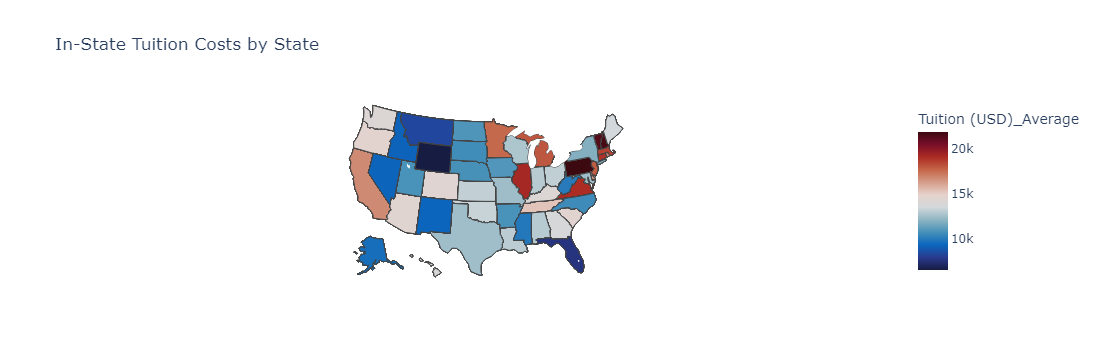

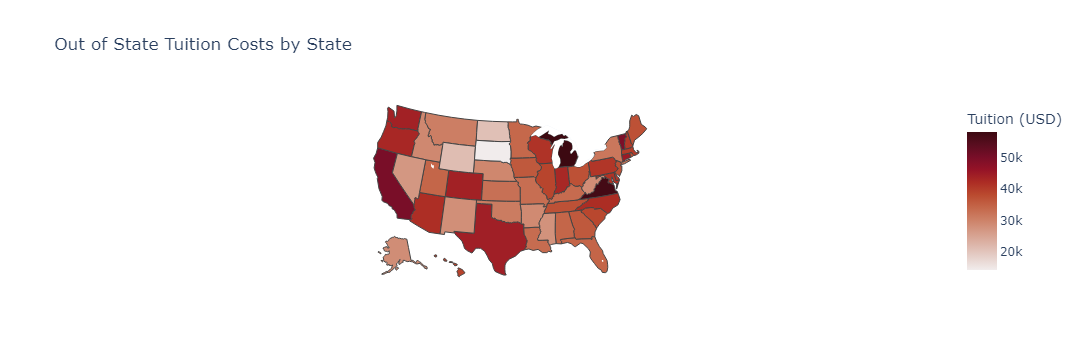

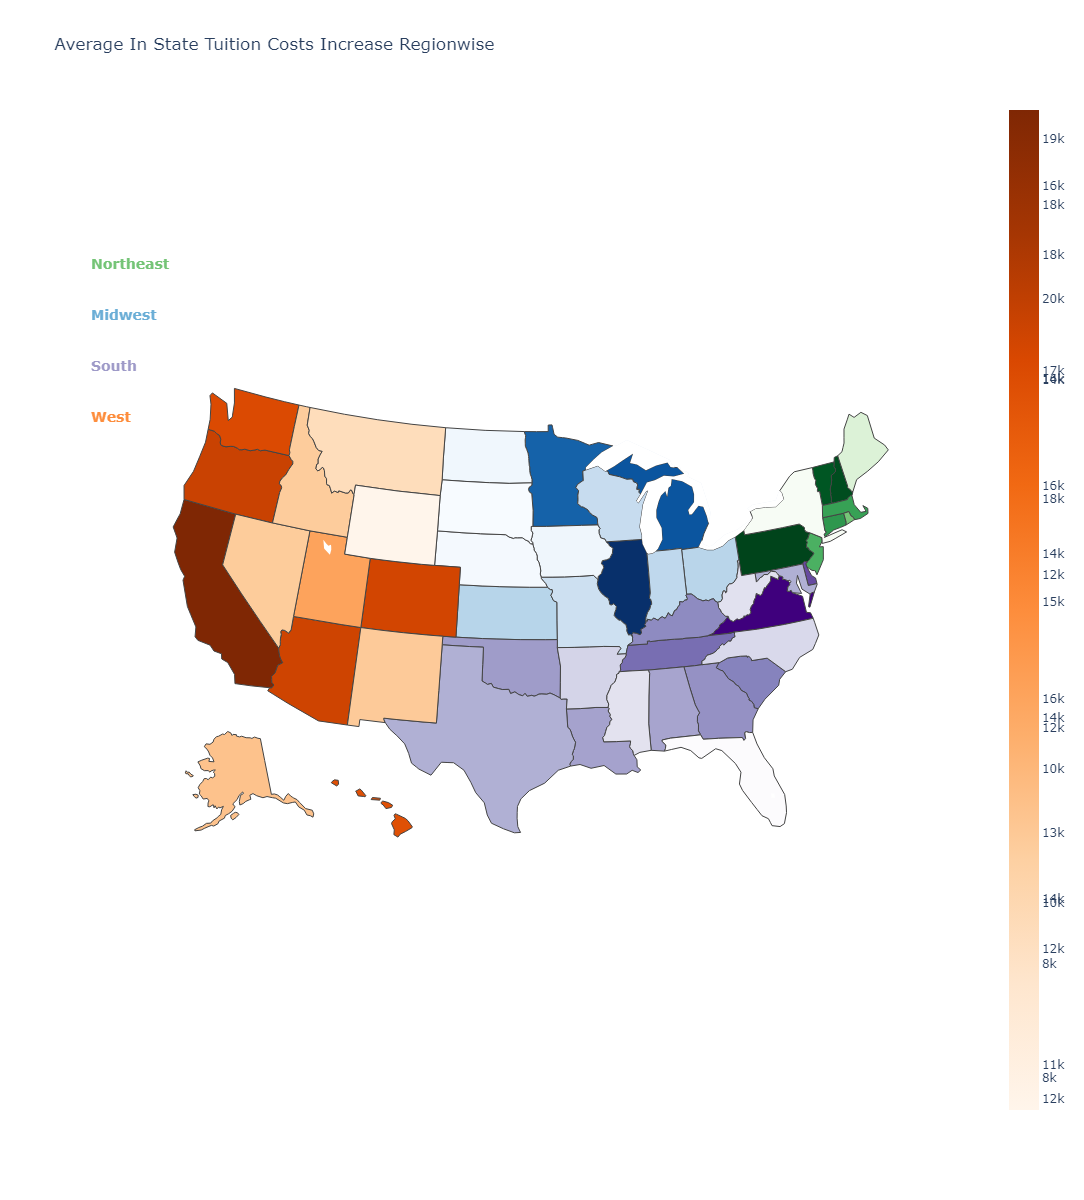

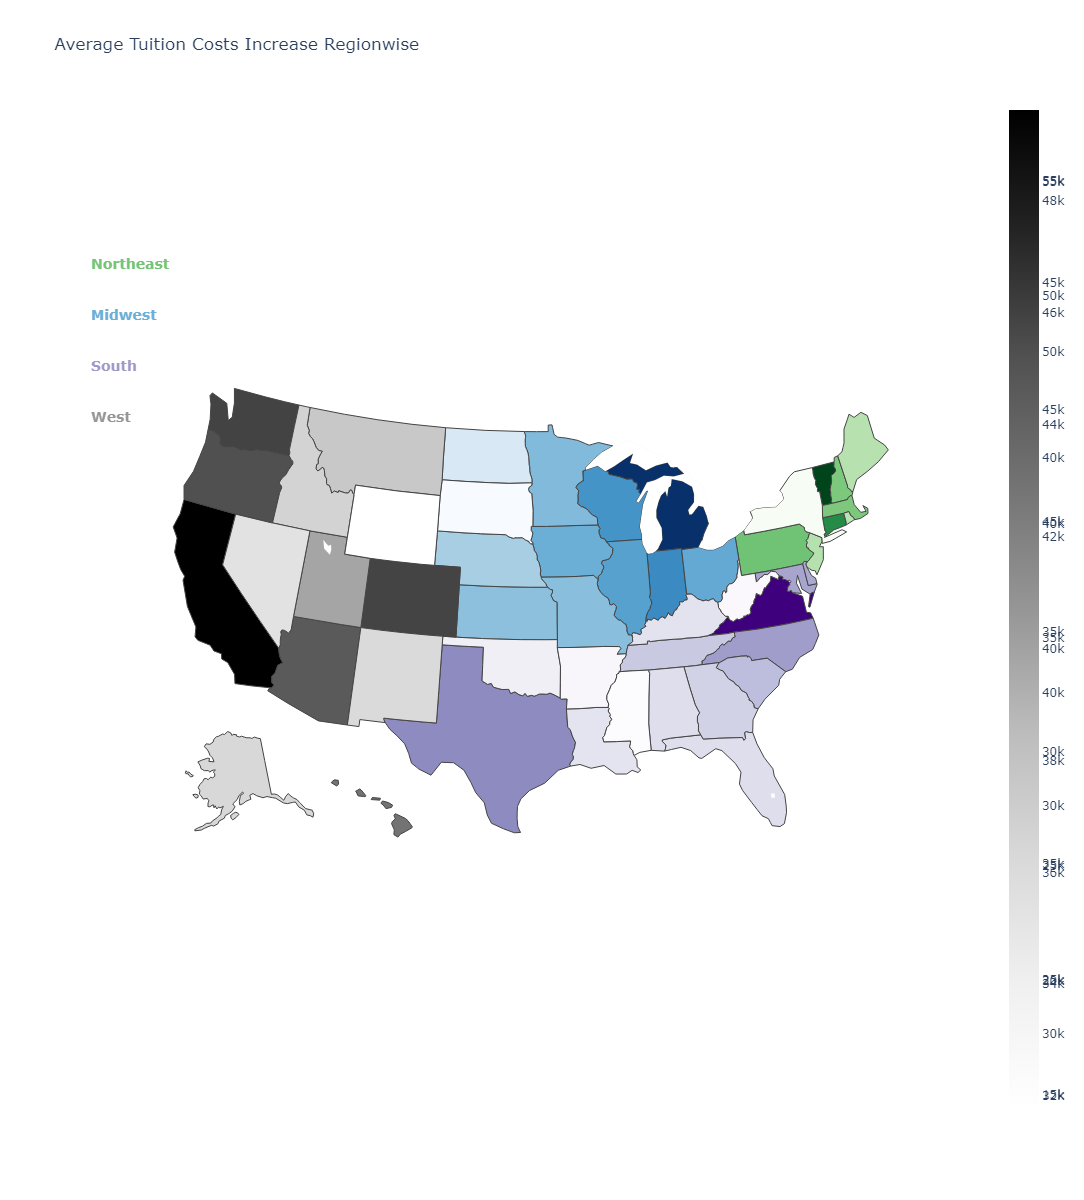

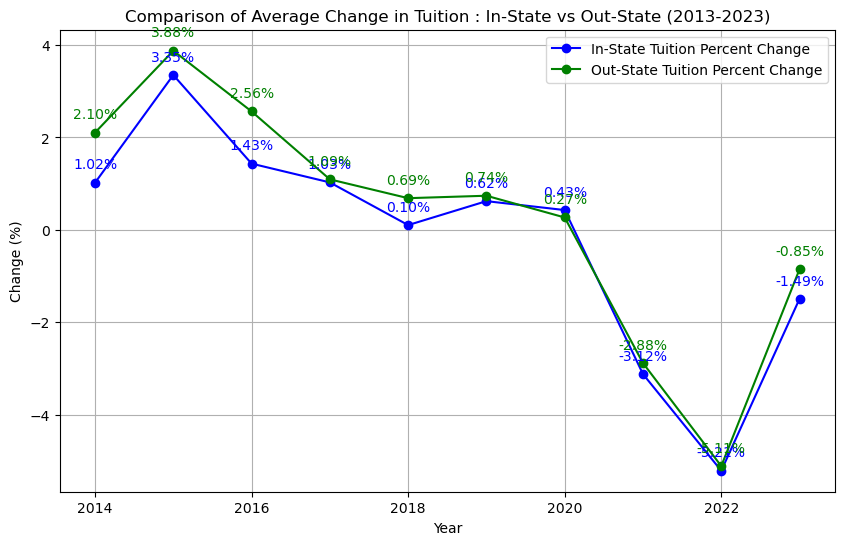

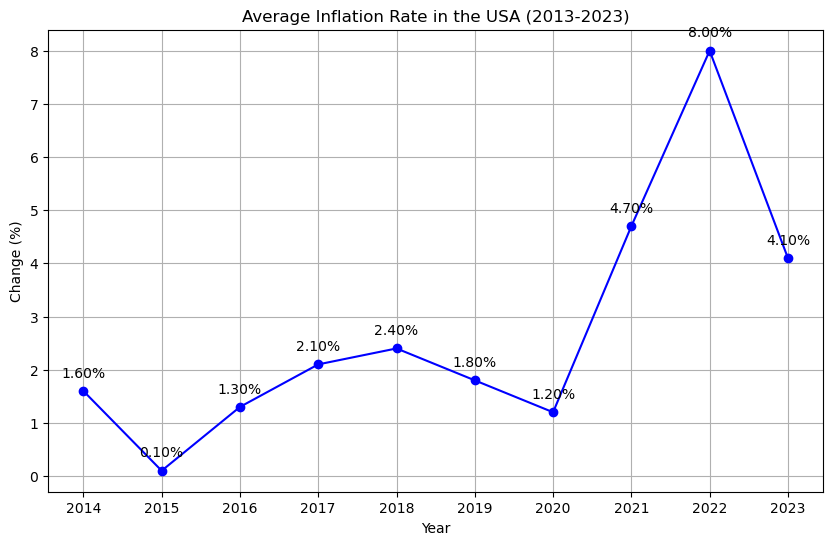

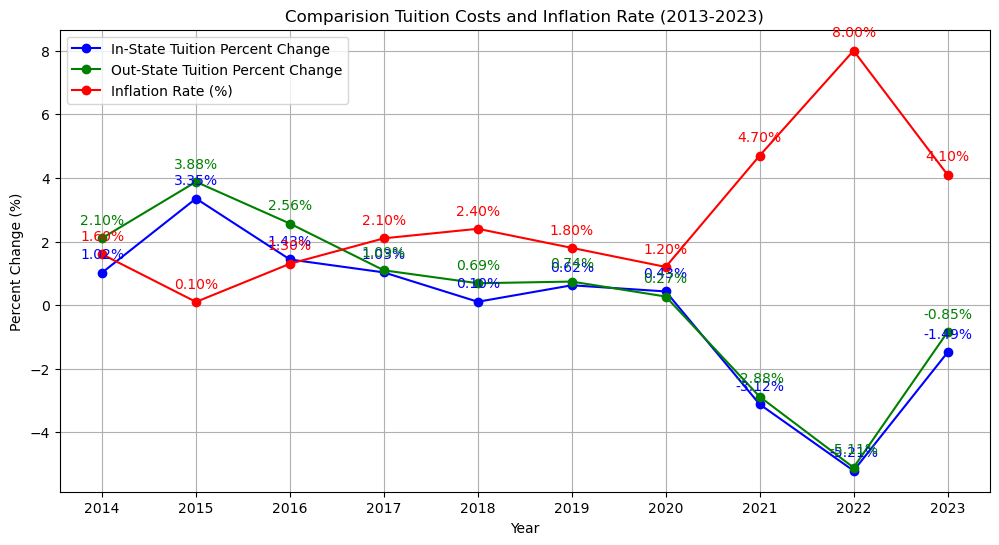

In [42]:
plotInstateheatmap()
plotoutstateheatmap()
plotinstateregionwise()
plotoutregionwise()
plotavgchangeinvsout()
plotavginflationrate()
plotavgfinalcomparision()